Run Setup before anything else, the other parts (h1 headings) are largely independent of each other. The Model evaluation will also include a synthetic analysis, for which the synthetic dataset is required.

An internet connection is required as the packages are reloaded, models and helper functions are downloaded from the anonymous repo and the CORA dataset is used.

This notebook has to be run outside the repo directory, i.e. in the current parent directory. This notebook will download the repo from the anonymous github and place it appropriately, if it cant' find the folder.

To quickly launch this notebook in Colab use this link: https://colab.research.google.com

## Setup

In [1]:
%%bash
directory="nc_spn"
zip_url="https://anonymous.4open.science/api/repo/NC-SP-MPNN-3137/zip"
zip_file="nc_spn.zip"

# Check if the directory exists
if [ ! -d "$directory" ]; then
    # download anonymous repository
    wget "$zip_url" -O "$zip_file"

    # Unzip the file into the directory
    unzip "$zip_file" -d "$directory"
    rm "$zip_file"

    echo "Repository downloaded!"
else
    echo "Directory already exists."
fi

Directory already exists.


In [2]:
%%capture
# get neccessary packages
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

# GPU accellerated TSNE
!pip install tsnecuda==3.0.1+cu122 -f https://tsnecuda.isx.ai/tsnecuda_stable.html

# for progress bars
!pip install tqdm

In [3]:
# get CORA data set
import torch_geometric.datasets as datasets

dataset = datasets.Planetoid(root='./', name='Cora', split='full')

# training and data preparation
import numpy as np
import torch
import torch.nn.functional as F
from networkx import grid_graph
from torch_geometric.utils import from_networkx

# data interpretation
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
from tsnecuda import TSNE as TSNE_cuda
from sklearn.manifold import TSNE as TSNE_sk
from tqdm.notebook import tqdm

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:87: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:98: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:125: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperators

In [4]:
# import models
from nc_spn.models.gcn import GCN
from nc_spn.models.jump_gcn import JumpKnowGCN
from nc_spn.models.spn import SPN
from nc_spn.models.train_models import get_trained_model, evaluate
from nc_spn.utils.shortest_paths import shortest_distances, shortest_distance_prediction_function

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Synthetic Data

labels are determined through a multiset of colours

In [6]:
synth_graph = from_networkx(grid_graph([50, 50])).to(device)
synth_graph.x = (torch.rand((synth_graph.num_nodes, 2), device=device) > 0.8).float()

adj, vals = shortest_distances(5, synth_graph.edge_index)

labels = torch.zeros((synth_graph.num_nodes, 2), dtype=torch.float, device=device)

for i in range(1, 6):
    n = adj.T[vals == i].T
    ax = torch.sparse_coo_tensor(n, torch.ones(n.size(1)), device=synth_graph.x.device) @ synth_graph.x
    labels += ax.to_dense() / ((3 - i)**2 + 1)

labels = labels.sum(dim=1)
labels -= labels.min()
labels /= labels.max()

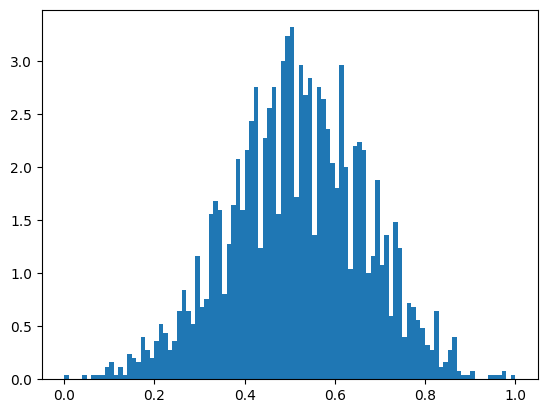

In [7]:
plt.hist(labels.cpu().numpy(), bins=100, density=True)
plt.show()

In [8]:
#synth_graph.y = ((labels<=.4) * 0 + \
#                ((labels>.4) & (labels <= .55)) * 1 + \
#                (labels>.55) * 2).long()
synth_graph.y = (labels > .55) * 1
synth_graph.num_classes = 2

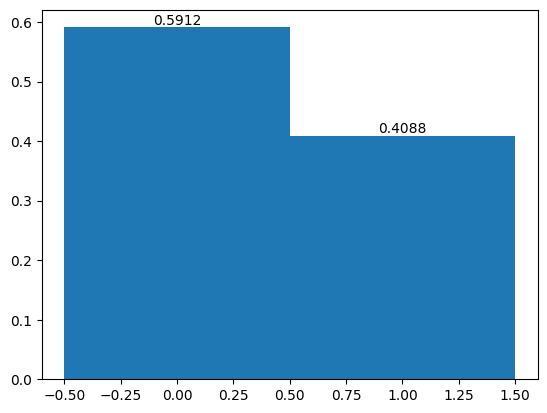

In [9]:
_, _, bars = plt.hist(synth_graph.y.cpu().numpy(), bins=np.arange(3) - .5, density=True)
plt.bar_label(bars)
plt.show()

In [10]:
# train, validation and test masks
# train ~50%, validation ~25% and test ~25%
train = torch.rand(labels.size(0), device=device) < .5
test = (torch.rand(labels.size(0), device=device) < .5) & ~train
synth_graph.train_mask = train
synth_graph.test_mask = test
synth_graph.val_mask = ~train & ~test

## Optimising Hyper Parameters

In [11]:
spn_params = {
    'num_features': dataset.num_features,
    'num_classes': dataset.num_classes,
    'emb_sizes': [64, 64],
    'max_distance': 3,
    'eps': 0,
    'learnable_eps': False,
    'dropout_prob': 0.1,
    'batch_norm': True,
    'device': device
}

### Determining the drop out rate

We will train some fairly "standard" models, that are identical apart from the dropout rate.

In [12]:
train_params = {
    "lr": 0.005,
    "prediction_function": shortest_distance_prediction_function(3, dataset.data.edge_index),
    "weight_decay": 0.0005,
    "epochs": 100,
    "max_patience": -1, # no early stopping, this will still take the best model
}

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/content/nc_spn/utils/shortest_paths.py:28: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  hop = torch.sparse.mm(k_hops, adjacency)


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 100 Epochs:
Train Accuracy: 0.9909, Val Accuracy: 0.8320, Test Accuracy: 0.7200


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 100 Epochs:
Train Accuracy: 0.9917, Val Accuracy: 0.8520, Test Accuracy: 0.7150


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 100 Epochs:
Train Accuracy: 0.9950, Val Accuracy: 0.8460, Test Accuracy: 0.7260


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 100 Epochs:
Train Accuracy: 0.9983, Val Accuracy: 0.8500, Test Accuracy: 0.7160


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 100 Epochs:
Train Accuracy: 0.9950, Val Accuracy: 0.8560, Test Accuracy: 0.7080


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 100 Epochs:
Train Accuracy: 0.9983, Val Accuracy: 0.8480, Test Accuracy: 0.7360


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 100 Epochs:
Train Accuracy: 0.9992, Val Accuracy: 0.8540, Test Accuracy: 0.7010


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 100 Epochs:
Train Accuracy: 0.9934, Val Accuracy: 0.8340, Test Accuracy: 0.7330


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 100 Epochs:
Train Accuracy: 0.9934, Val Accuracy: 0.8560, Test Accuracy: 0.7540


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 100 Epochs:
Train Accuracy: 0.9776, Val Accuracy: 0.8220, Test Accuracy: 0.7240


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 100 Epochs:
Train Accuracy: 0.1623, Val Accuracy: 0.3160, Test Accuracy: 0.1440


Text(0, 0.5, 'Validation accuracy')

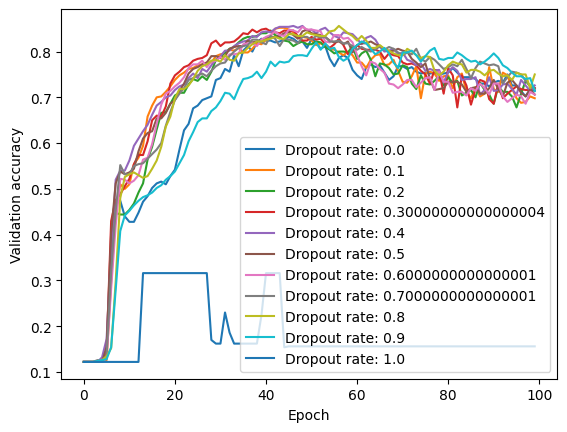

In [13]:
validation_accs = []
rates = np.linspace(0, 1, 11)
for dropout_rate in rates:
    torch.manual_seed(42) # cpu seed
    torch.cuda.manual_seed(42) # gpu seed

    spn_params['dropout_prob'] = dropout_rate
    spn_mod, spn_acc = get_trained_model("spn", dataset.data, spn_params, train_params)
    validation_accs.append(spn_acc)

for rate, acc in zip(rates, validation_accs):
    plt.plot(acc, label=f'Dropout rate: {rate}')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')

Unless absurdly high, the dropout rate does not seem to have a gi impact on the prediction accuracy

In [14]:
spn_params['dropout_prob'] = 0.1

### Weight decay

In [15]:
train_params = {
    "lr": 0.005,
    "prediction_function": shortest_distance_prediction_function(3, dataset.data.edge_index),
    "weight_decay": 0.0005,
    "epochs": 100,
    "max_patience": -1, # no early stopping, this will still take the best model
}

Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 100 Epochs:
Train Accuracy: 0.9934, Val Accuracy: 0.8460, Test Accuracy: 0.7070


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 100 Epochs:
Train Accuracy: 0.9942, Val Accuracy: 0.8540, Test Accuracy: 0.7380


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 100 Epochs:
Train Accuracy: 0.9909, Val Accuracy: 0.8440, Test Accuracy: 0.7220


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 100 Epochs:
Train Accuracy: 0.9636, Val Accuracy: 0.8140, Test Accuracy: 0.7460


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 100 Epochs:
Train Accuracy: 0.8750, Val Accuracy: 0.7420, Test Accuracy: 0.7710


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 100 Epochs:
Train Accuracy: 0.8394, Val Accuracy: 0.7600, Test Accuracy: 0.7330


Text(0, 0.5, 'Validation accuracy')

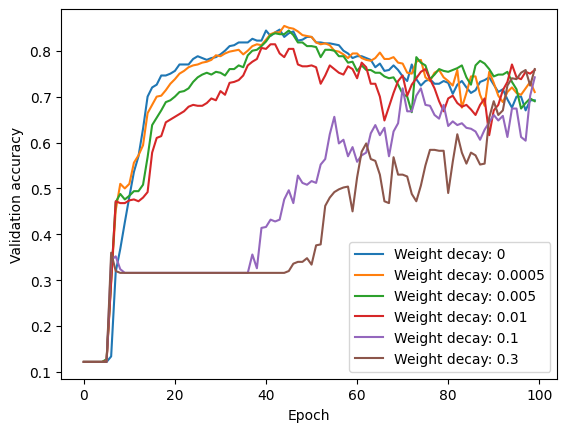

In [16]:
validation_accs = []
for decay in [0, 0.0005, 0.005, 0.01, 0.1, 0.3]:
    torch.manual_seed(42) # cpu seed
    torch.cuda.manual_seed(42) # gpu seed

    train_params['weight_decay'] = decay
    spn_mod, spn_acc = get_trained_model("spn", dataset.data, spn_params, train_params)
    validation_accs.append(spn_acc)

for decay, acc in zip([0, 0.0005, 0.005, 0.01, 0.1, 0.3], validation_accs):
    plt.plot(acc, label=f'Weight decay: {decay}')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')

We will use 0.005, 10x the regular weight decay

In [17]:
train_params['weight_decay'] = 0.005

### Number of hops to consider

Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 100 Epochs:
Train Accuracy: 0.9810, Val Accuracy: 0.8440, Test Accuracy: 0.7830


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 100 Epochs:
Train Accuracy: 0.9785, Val Accuracy: 0.8500, Test Accuracy: 0.6590


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 100 Epochs:
Train Accuracy: 0.9876, Val Accuracy: 0.8560, Test Accuracy: 0.6610


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 100 Epochs:
Train Accuracy: 0.9909, Val Accuracy: 0.8380, Test Accuracy: 0.7700


Text(0, 0.5, 'Validation accuracy')

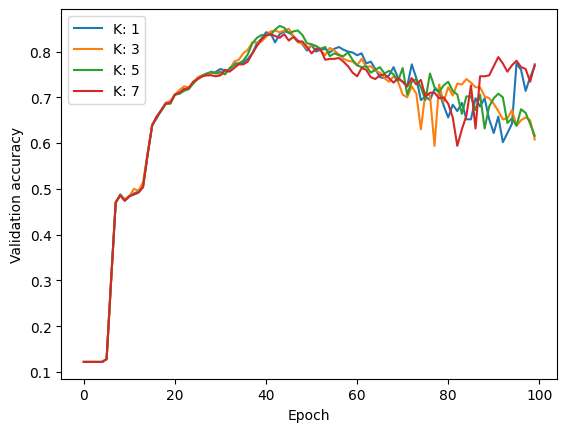

In [18]:
validation_accs = []
hops = [1, 3, 5, 7]
for hop in hops:
    torch.manual_seed(42)
    train_params['prediction_function'] = shortest_distance_prediction_function(hop, dataset.data.edge_index)
    spn_mod, spn_acc = get_trained_model("spn", dataset.data, spn_params, train_params)
    validation_accs.append(spn_acc)

for hop, acc in zip(hops, validation_accs):
    plt.plot(acc, label=f'K: {hop}')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')

We want to consider multiple Ks anyways, so this is irrelevant

## SPN Training

In [19]:
spn_mod_a, spn_acc = get_trained_model("spn", dataset.data, spn_params, train_params)

Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 100 Epochs:
Train Accuracy: 0.8361, Val Accuracy: 0.7800, Test Accuracy: 0.6670


In [20]:
spn_mod_b, spn_acc_b = get_trained_model("spn", dataset.data, {
    'num_features': dataset.num_features,
    'num_classes': dataset.num_classes,
    'emb_sizes': [64, 64, 64],
    'max_distance': 3,
    'eps': 0,
    'learnable_eps': False,
    'dropout_prob': 0.1,
    'batch_norm': True,
    'device': device
}, {
    "lr": 0.005,
    "weight_decay": 0.0005,
    "epochs": 150,
    "max_patience": -1, # no early stopping, this will still take the best model
})

Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 150 Epochs:
Train Accuracy: 0.9164, Val Accuracy: 0.8320, Test Accuracy: 0.7810


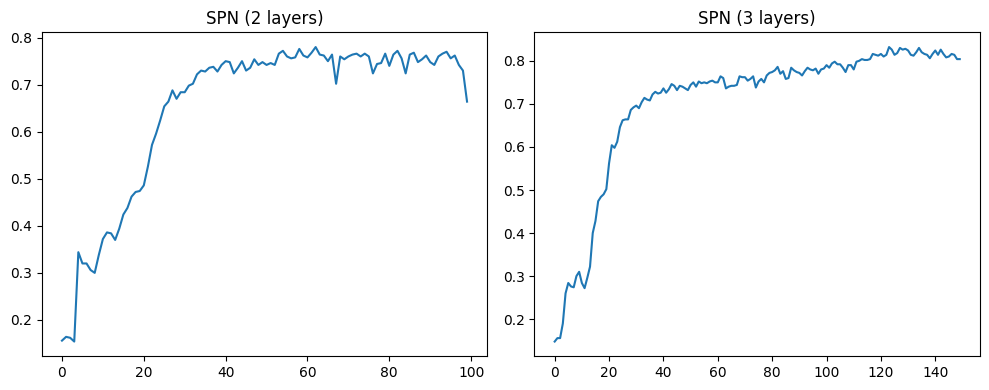

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(spn_acc)
axs[0].set_title('SPN (2 layers)')

axs[1].plot(spn_acc_b)
axs[1].set_title('SPN (3 layers)')

fig.tight_layout()

# Model Evaluation

## Evaluation Functions

Required to evaluate both Cora and the synthetic graph

### Prediction accuracies

In [22]:
def generate_latex_string(mp_iterations, max_distances, gcn_accs, jump_accs, spn_accs, output_digits=2, caption=""):
    s = "    " # spacing for intendation

    # Create the LaTeX table string
    latex_table = "\\begin{table}[h]\n"
    latex_table += s + "\\centering\n"
    latex_table += s + "\\begin{tabular}{l" + "c" * len(mp_iterations) + "}\n"
    latex_table += s*2 + "\\toprule\n"
    latex_table += s*2 + "Model & " + " & ".join([f"{i} Iterations" for i in mp_iterations]) + "\\\\\n"
    latex_table += s*2 + "\\midrule\n"


    # Add GCN results
    latex_table += s*2 + f"GCN & {' & '.join([f'{acc:.{output_digits}f}' for acc in gcn_accs])} \\\\\n"
    # Add JumpGCN results
    latex_table += s*2 + f"JumpGCN & {' & '.join([f'{acc:.{output_digits}f}' for acc in jump_accs])} \\\\\n"
    latex_table += s*2 + "\\midrule\n"

    # Add SPN results for different max hops
    for i, hop in enumerate(max_distances):
      accuracies = [
          f'{acc:.{output_digits}f}'
          for acc in spn_accs[i * len(mp_iterations) : (i+1) * len(mp_iterations)]
      ]
      latex_table += s*2 + f"SPN K={hop} & {' & '.join(accuracies)} \\\\\n"

    latex_table += s*2 + "\\bottomrule\n"
    latex_table += s + "\\end{tabular}\n"
    latex_table += s + "\\caption{" + caption + "}\n"
    latex_table += s + "\\label{tab:model_accuracies}\n"
    latex_table += "\\end{table}"

    return latex_table

### Node Embeddings

In [23]:
from ctypes import ArgumentError
def dimension_reduction(embeddings) -> pd.DataFrame:
  """
  Produces Dimension reduced representations for node embeddings.
  :param embeddings: The original feature embeddings.
  :return: The features embedded in 2D.
  """
  # move node embedings to cpu and turn it into numpy arrays
  # although the TSNE itself runs on GPU, the embeddings need to be on CPU at the start of the tranformation
  embed = embeddings.cpu().detach().numpy()

  # use default parameters of sklearn implementation
  rd_embed = TSNE_cuda(n_components=2, perplexity=15, learning_rate=10, min_grad_norm=1e-07).fit_transform(embed)

  # in case of dublicate values TSNE might produce all nans
  count = -5
  while not np.all(np.isfinite(rd_embed)):
      embed = (embeddings + torch.normal(0.0, 2**count, size=embeddings.shape, device=embeddings.device)).cpu().detach().numpy()
      rd_embed = TSNE_cuda(n_components=2, perplexity=15, learning_rate=10, min_grad_norm=1e-07).fit_transform(embed)
      print(count)
      count += 1
      if count >= 100:
        raise ArgumentError('Cannot produce Embeddings!')

  rd_embed = pd.DataFrame(rd_embed, columns=['x', 'y'])
  return rd_embed

In [24]:
def prepare_embedding_plotting(mp_iters, max_hops, gcn_embs, jump_embs, spn_embs, lablels):
    plot_data = []
    for col in range(len(mp_iters)):
        column_data = []

        embeddings = gcn_embs[col]
        rd_embed = dimension_reduction(embeddings)
        rd_embed['col'] = lablels
        column_data.append(rd_embed)

        embeddings = jump_embs[col]
        rd_embed = dimension_reduction(embeddings)
        rd_embed['col'] = lablels
        column_data.append(rd_embed)

        for i in range(len(max_hops)):
            embeddings = spn_embs[len(mp_iters) * i + col]
            rd_embed = dimension_reduction(embeddings)
            rd_embed['col'] = lablels
            column_data.append(rd_embed)
        plot_data.append(column_data)
    return plot_data

In [25]:
def plot_embeddings(embedding_data):
    col_count = len(embedding_data)
    row_count = len(embedding_data[0])
    gcn_fig, gax = plt.subplots(2, col_count, figsize=(col_count*2.2, 3))
    spn_fig, sax = plt.subplots(row_count - 2, col_count, figsize=(col_count*2.2, row_count * 1.5 - 3))

    for col in range(len(embedding_data)):
        gax[0, col].set_title(f'{mp_iters[col]} MP Layer(s)')
        sax[0, col].set_title(f'{mp_iters[col]} MP Layer(s)')

        for row in range(len(embedding_data[col])):
            axs = gax if row < 2 else sax
            r = row if row < 2 else row - 2
            axs[r, col].scatter(
                embedding_data[col][row]['x'],
                embedding_data[col][row]['y'],
                c=embedding_data[col][row]['col'],
                cmap='tab10',
                marker='.',
                s=1,
            )
            axs[r, col].set_xticks([])
            axs[r, col].set_yticks([])


    gax[0, 0].set_ylabel('GCN')
    gax[1, 0].set_ylabel('JumpGCN')
    for i, hop in enumerate(max_hops):
        sax[i, 0].set_ylabel(f'SPN K={hop}')

    gcn_fig.tight_layout()
    spn_fig.tight_layout()
    return (gcn_fig, gax), (spn_fig, sax)

### Pickle everything

In [26]:
def save_data(
    gcn_mods,  gcn_embs,  gcn_accs,  gcn_val_accs,
    jump_mods, jump_embs, jump_accs, jump_val_accs,
    spn_mods,  spn_embs,  spn_accs,  spn_val_accs,
    plotting_data,
    data_file
):
    # Create a nested dictionary
    results = {
        'models': {
            'gcn': gcn_mods,
            'jump_gcn': jump_mods,
            'spn': spn_mods
        },
        'embeddings': {
            'gcn': gcn_embs,
            'jump_gcn': jump_embs,
            'spn': spn_embs
        },
        'accuracies': {
            'gcn': {
                'val': gcn_accs,
                'test': gcn_val_accs
            },
            'jump_gcn': {
                'val': jump_accs,
                'test': jump_val_accs
            },
            'spn': {
                'val': spn_accs,
                'test': spn_val_accs
            }
        },
        'plotting_data': plotting_data
    }

    # Write the dictionary to disk using pickle
    with open(data_file, 'wb') as f:
        pkl.dump(results, f)

### Visualize Training Progress

In [27]:
def training_report(mp_iters, max_hops, gcn_val_hist, jump_val_hist, spn_val_hist):
    col_count = len(mp_iters)
    row_count = 2 + len(max_hops)
    fig, axs = plt.subplots(row_count, col_count, figsize=(col_count*2.2, row_count * 1.5), sharex='all', sharey='all')

    for col in range(len(mp_iters)):
        axs[0, col].set_title(f'{mp_iters[col]} MP Layer(s)')

        axs[0, col].plot(gcn_val_hist[col])
        axs[1, col].plot(jump_val_hist[col])
        for i, hop in enumerate(max_hops):
            axs[2 + i, col].plot(spn_val_hist[col * len(max_hops) + i])

        axs[0, col].set_xticks([])
        axs[1, col].set_xticks([])
        if col != 0:
            axs[0, col].set_yticks([])
            axs[1, col].set_yticks([])
        for i, hop in enumerate(max_hops):
            axs[2 + i, col].set_xticks([])
            if col != 0:
                axs[2 + i, col].set_yticks([])

    axs[0, 0].set_ylabel('GCN')
    axs[1, 0].set_ylabel('JumpGCN')
    for i, hop in enumerate(max_hops):
        axs[2 + i, 0].set_ylabel(f'SPN K={hop}')

    fig.tight_layout()
    return fig, axs

## Cora performance

In term of K and iterations

In [28]:
gcn_params = {
    'input_dim': dataset.num_features,
    'hid_dim': 64,
    'n_classes': dataset.num_classes,
    'dropout_ratio': 0.1,
}
spn_params = {
  'num_features': dataset.num_features,
  'num_classes': dataset.num_classes,
  # 'emb_sizes': [64, 64],  -> will be set in each iteration
  # 'max_distance': 3,      -> will be set in each iteration
  'eps': 0,
  'learnable_eps': True,
  'dropout_prob': 0.1,
  'batch_norm': True,
  'device': device
}
train_params = {
    "lr": 0.005,
    "weight_decay": 0.0005,
    "epochs": 100,
    "max_patience": 20,
}

In [29]:
mp_iters = [1, 3, 5, 10, 20]
max_hops = [1, 3, 5, 7]

### GCNs without Jumping Knowledge Connections

In [30]:
# train models on CORA
gcn_mods, gcn_accs = [], []
gcn_val_accs = [] #useful for debugging, irrelevant beyond that
for mp_iter in tqdm(mp_iters):
    torch.cuda.manual_seed(42)
    torch.manual_seed(42)

    gcn_params['n_layers'] = mp_iter

    mod, acc = get_trained_model('gcn', dataset.data, gcn_params, train_params)
    test_acc = evaluate(mod, dataset.data, dataset.test_mask)

    gcn_mods.append(mod)
    gcn_val_accs.append(acc)
    gcn_accs.append(test_acc)

  0%|          | 0/5 [00:00<?, ?it/s]

Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 44 Epochs:
Train Accuracy: 0.9843, Val Accuracy: 0.8880, Test Accuracy: 0.8600


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 64 Epochs:
Train Accuracy: 0.9644, Val Accuracy: 0.8840, Test Accuracy: 0.8380


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 94 Epochs:
Train Accuracy: 0.9429, Val Accuracy: 0.8560, Test Accuracy: 0.8270


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 21 Epochs:
Train Accuracy: 0.2823, Val Accuracy: 0.3160, Test Accuracy: 0.3190


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 21 Epochs:
Train Accuracy: 0.2823, Val Accuracy: 0.3160, Test Accuracy: 0.3190


In [31]:
# get node embeddings
gcn_embs = []
for mod in tqdm(gcn_mods):
    gcn_embs.append(mod.generate_node_embeddings(dataset.data))

  0%|          | 0/5 [00:00<?, ?it/s]

### GCNs with Jumping Knowledge Connections

In [32]:
# train models on CORA
jump_mods, jump_accs = [], []
jump_val_accs = []
for mp_iter in tqdm(mp_iters):
    torch.cuda.manual_seed(42)
    torch.manual_seed(42)

    gcn_params['n_layers'] = mp_iter

    mod, acc = get_trained_model('jump_gcn', dataset.data, gcn_params, train_params)
    test_acc = evaluate(mod, dataset.data, dataset.test_mask)

    jump_mods.append(mod)
    jump_val_accs.append(acc)
    jump_accs.append(test_acc)

  0%|          | 0/5 [00:00<?, ?it/s]

Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 41 Epochs:
Train Accuracy: 0.9826, Val Accuracy: 0.8840, Test Accuracy: 0.8580


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 52 Epochs:
Train Accuracy: 0.9876, Val Accuracy: 0.8860, Test Accuracy: 0.8460


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 44 Epochs:
Train Accuracy: 0.9834, Val Accuracy: 0.8780, Test Accuracy: 0.8540


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 50 Epochs:
Train Accuracy: 0.9843, Val Accuracy: 0.8880, Test Accuracy: 0.8500


Loss: unknown:   0%|          | 0/100 [00:00<?, ?it/s]

Training ended after 52 Epochs:
Train Accuracy: 0.9892, Val Accuracy: 0.8800, Test Accuracy: 0.8570


In [33]:
# get node embeddings
jump_embs = []
for mod in tqdm(jump_mods):
    jump_embs.append(mod.generate_node_embeddings(dataset.data))

  0%|          | 0/5 [00:00<?, ?it/s]

### SPN

In [34]:
train_params['epochs'] = 150
train_params['max_patience'] = 50 # the SPN takes longer to get going during training
train_params['weight_decay'] = 0.001 # The SPN has a much larger tendency to overfit

In [35]:
# train models on CORA
spn_mods, spn_accs = [], []
spn_val_accs = []
for hops in tqdm(max_hops):
    for mp_iter in tqdm(mp_iters):
        torch.cuda.manual_seed(42)
        torch.manual_seed(42)

        spn_params['emb_sizes'] = [64] * (mp_iter+1)
        spn_params['max_distance'] = hops
        train_params['prediction_function'] = shortest_distance_prediction_function(hops, dataset.data.edge_index)

        mod, acc = get_trained_model("spn", dataset.data, spn_params, train_params)
        test_acc = evaluate(mod, dataset.data, dataset.test_mask)

        spn_mods.append(mod)
        spn_val_accs.append(acc)
        spn_accs.append(test_acc)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 74 Epochs:
Train Accuracy: 0.9992, Val Accuracy: 0.5480, Test Accuracy: 0.4350


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 85 Epochs:
Train Accuracy: 0.9884, Val Accuracy: 0.8280, Test Accuracy: 0.7300


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 150 Epochs:
Train Accuracy: 0.9669, Val Accuracy: 0.8200, Test Accuracy: 0.7830


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 150 Epochs:
Train Accuracy: 0.8245, Val Accuracy: 0.7820, Test Accuracy: 0.7610


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 150 Epochs:
Train Accuracy: 0.5613, Val Accuracy: 0.6080, Test Accuracy: 0.5580


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 98 Epochs:
Train Accuracy: 0.9925, Val Accuracy: 0.8400, Test Accuracy: 0.7400


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 150 Epochs:
Train Accuracy: 0.8187, Val Accuracy: 0.7700, Test Accuracy: 0.7570


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 124 Epochs:
Train Accuracy: 0.6391, Val Accuracy: 0.6260, Test Accuracy: 0.6010


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 150 Epochs:
Train Accuracy: 0.4536, Val Accuracy: 0.6180, Test Accuracy: 0.4310


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 55 Epochs:
Train Accuracy: 0.2376, Val Accuracy: 0.2360, Test Accuracy: 0.2260


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 86 Epochs:
Train Accuracy: 0.9826, Val Accuracy: 0.7880, Test Accuracy: 0.5700


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 150 Epochs:
Train Accuracy: 0.5820, Val Accuracy: 0.6960, Test Accuracy: 0.5680


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 150 Epochs:
Train Accuracy: 0.2988, Val Accuracy: 0.5240, Test Accuracy: 0.2720


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 112 Epochs:
Train Accuracy: 0.2086, Val Accuracy: 0.2280, Test Accuracy: 0.1980


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 53 Epochs:
Train Accuracy: 0.1846, Val Accuracy: 0.3040, Test Accuracy: 0.1660


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 100 Epochs:
Train Accuracy: 0.3899, Val Accuracy: 0.5920, Test Accuracy: 0.2980


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 122 Epochs:
Train Accuracy: 0.1722, Val Accuracy: 0.5140, Test Accuracy: 0.1730


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 150 Epochs:
Train Accuracy: 0.0952, Val Accuracy: 0.2880, Test Accuracy: 0.0910


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 67 Epochs:
Train Accuracy: 0.1846, Val Accuracy: 0.1860, Test Accuracy: 0.1670


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 101 Epochs:
Train Accuracy: 0.1440, Val Accuracy: 0.3300, Test Accuracy: 0.1350


In [36]:
# get node embeddings
spn_embs = []
for mod in tqdm(spn_mods):
    spn_embs.append(mod.generate_node_embeddings(dataset.data))

  0%|          | 0/20 [00:00<?, ?it/s]

### Visualize and save Data

In [37]:
print(generate_latex_string(
    mp_iters,
    max_hops,
    gcn_accs,
    jump_accs,
    spn_accs,
    3,
    "Preediction accuracies on the CORA dataset, using the Testset."
))

\begin{table}[h]
    \centering
    \begin{tabular}{lccccc}
        \toprule
        Model & 1 Iterations & 3 Iterations & 5 Iterations & 10 Iterations & 20 Iterations\\
        \midrule
        GCN & 0.860 & 0.838 & 0.827 & 0.319 & 0.319 \\
        JumpGCN & 0.858 & 0.846 & 0.854 & 0.850 & 0.857 \\
        \midrule
        SPN K=1 & 0.435 & 0.730 & 0.783 & 0.761 & 0.558 \\
        SPN K=3 & 0.740 & 0.757 & 0.601 & 0.431 & 0.226 \\
        SPN K=5 & 0.570 & 0.568 & 0.272 & 0.198 & 0.166 \\
        SPN K=7 & 0.298 & 0.173 & 0.091 & 0.167 & 0.135 \\
        \bottomrule
    \end{tabular}
    \caption{Preediction accuracies on the CORA dataset, using the Testset.}
    \label{tab:model_accuracies}
\end{table}


In [38]:
plotting_data = prepare_embedding_plotting(mp_iters, max_hops, gcn_embs, jump_embs, spn_embs, dataset.data.y.cpu().detach().numpy())

-5
-5
-5
-5
-5
-5
-5
-5
-5


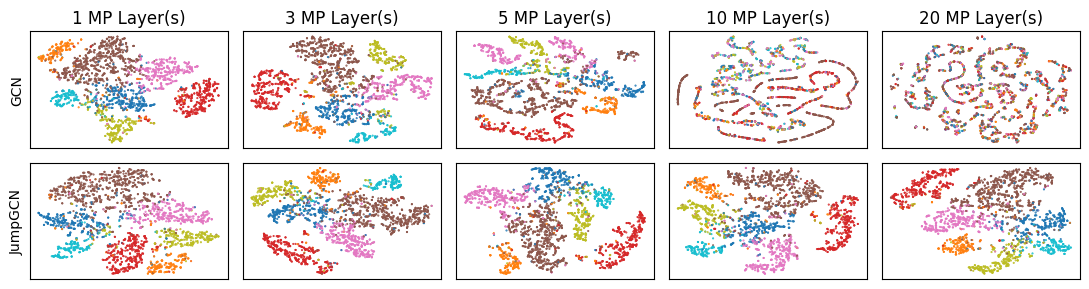

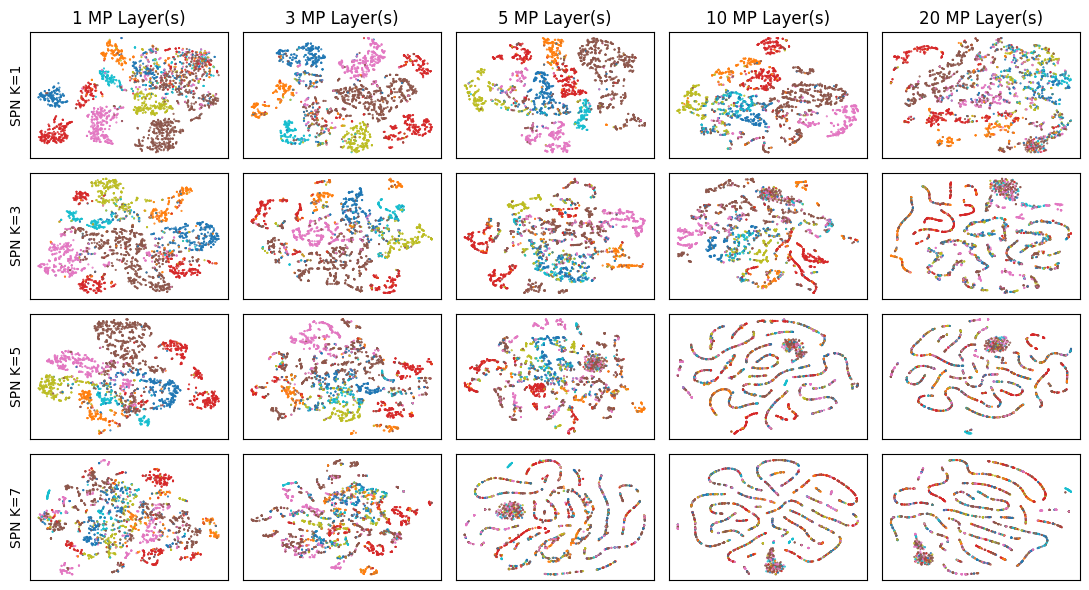

In [39]:
(fig_gcn, _), (fig_spn, _) = plot_embeddings(plotting_data)

In [40]:
fig_gcn.show()
fig_gcn.savefig("cora_gcn_embeddings.png", dpi=512)

In [41]:

fig_spn.show()
fig_spn.savefig("cora_spn_embeddings.png", dpi=512)

In [42]:
save_data(
    gcn_mods,  gcn_embs,  gcn_accs,  gcn_val_accs,
    jump_mods, jump_embs, jump_accs, jump_val_accs,
    spn_mods,  spn_embs,  spn_accs,  spn_val_accs,
    plotting_data,
    "cora_data.pkl"
)

In [43]:
# Load data from the pickle file
with open('cora_data.pkl', 'rb') as f:
    loaded_data = pkl.load(f)

# copy the variables
gcn_mods = loaded_data['models']['gcn']
gcn_embs = loaded_data['embeddings']['gcn']
gcn_accs = loaded_data['accuracies']['gcn']['val']
gcn_val_accs = loaded_data['accuracies']['gcn']['test']
jump_mods = loaded_data['models']['jump_gcn']
jump_embs = loaded_data['embeddings']['jump_gcn']
jump_accs = loaded_data['accuracies']['jump_gcn']['val']
jump_val_accs = loaded_data['accuracies']['jump_gcn']['test']
spn_mods = loaded_data['models']['spn']
spn_embs = loaded_data['embeddings']['spn']
spn_accs = loaded_data['accuracies']['spn']['val']
spn_val_accs = loaded_data['accuracies']['spn']['test']
plotting_data = loaded_data['plotting_data']

(<Figure size 1100x900 with 30 Axes>,
 array([[<Axes: title={'center': '1 MP Layer(s)'}, ylabel='GCN'>,
         <Axes: title={'center': '3 MP Layer(s)'}>,
         <Axes: title={'center': '5 MP Layer(s)'}>,
         <Axes: title={'center': '10 MP Layer(s)'}>,
         <Axes: title={'center': '20 MP Layer(s)'}>],
        [<Axes: ylabel='JumpGCN'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='SPN K=1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='SPN K=3'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='SPN K=5'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='SPN K=7'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >]],
       dtype=object))

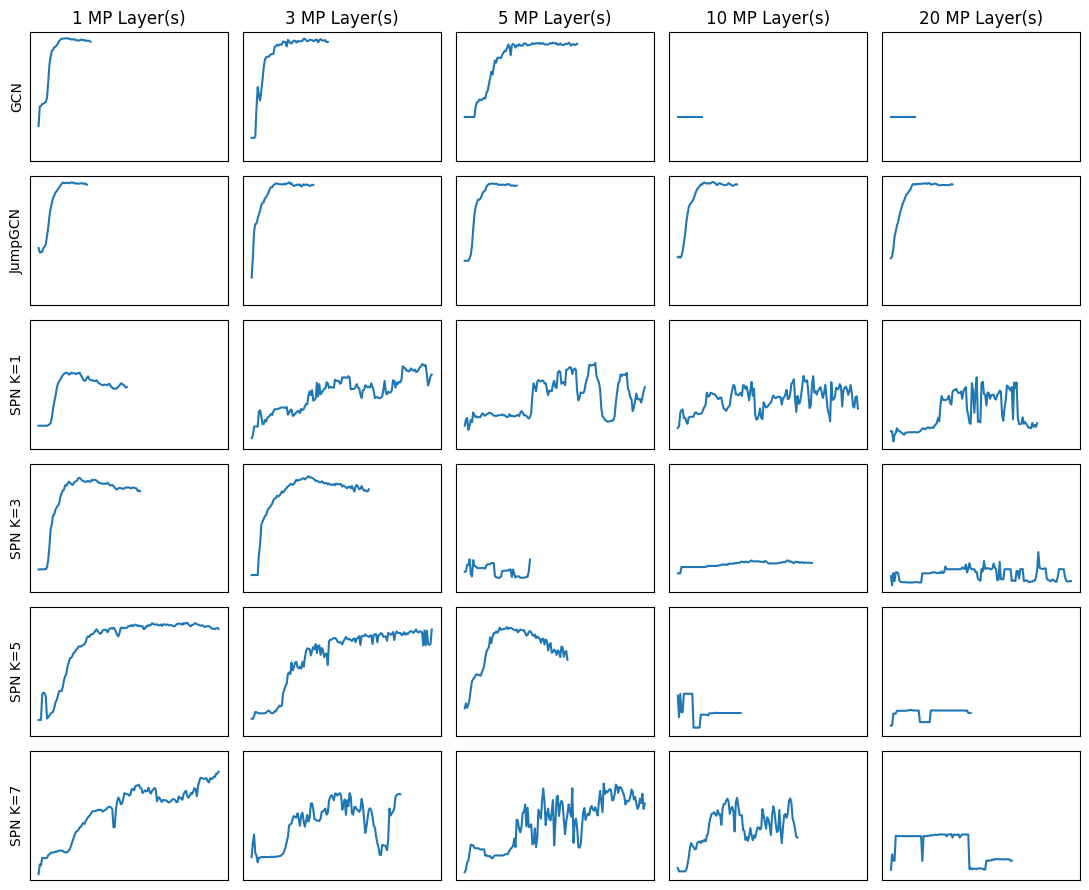

In [44]:
training_report(mp_iters, max_hops, gcn_val_accs, jump_val_accs, spn_val_accs)

## Synthetic Dataset

In [45]:
gcn_params = {
    'input_dim': synth_graph.num_features,
    'hid_dim': 64,
    'n_classes': synth_graph.num_classes,
    'dropout_ratio': 0.1,
}
spn_params = {
  'num_features': synth_graph.num_features,
  'num_classes': synth_graph.num_classes,
  # 'emb_sizes': [64, 64],  -> will be set in each iteration
  # 'max_distance': 3,      -> will be set in each iteration
  'eps': 0,
  'learnable_eps': True,
  'dropout_prob': 0.1,
  'batch_norm': True,
  'device': device
}
train_params = {
    "lr": 0.0001,
    "weight_decay": 0.001,
    "epochs": 150,
    "max_patience": 30, # training on GPU is relatively fast and the models take a bit to get goin sometimes
}

In [46]:
mp_iters = [1, 3, 5, 10]
max_hops = [1, 3, 5]

### GCN without Jumping Knowledge Connections

In [47]:
# train model on synthetic graph
gcn_mods, gcn_accs = [], []
gcn_val_accs = []
for mp_iter in tqdm(mp_iters):
    torch.cuda.manual_seed(42)
    torch.manual_seed(42)

    gcn_params['n_layers'] = mp_iter

    mod, acc = get_trained_model('gcn', synth_graph, gcn_params, train_params)
    test_acc = evaluate(mod, synth_graph, synth_graph.test_mask)

    gcn_mods.append(mod)
    gcn_val_accs.append(acc)
    gcn_accs.append(test_acc)

  0%|          | 0/4 [00:00<?, ?it/s]

Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 31 Epochs:
Train Accuracy: 0.5941, Val Accuracy: 0.5793, Test Accuracy: 0.5977


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 31 Epochs:
Train Accuracy: 0.5941, Val Accuracy: 0.5793, Test Accuracy: 0.5977


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 31 Epochs:
Train Accuracy: 0.4059, Val Accuracy: 0.4207, Test Accuracy: 0.4023


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 31 Epochs:
Train Accuracy: 0.4059, Val Accuracy: 0.4207, Test Accuracy: 0.4023


In [48]:
# node embeddings
gcn_embs = []
for mod in tqdm(gcn_mods):
    gcn_embs.append(mod.generate_node_embeddings(synth_graph))

  0%|          | 0/4 [00:00<?, ?it/s]

### GCN with Jumping Knowledge Connections

In [49]:
# train model on synthetic graph
jump_mods, jump_accs = [], []
jump_val_accs = []
for mp_iter in tqdm(mp_iters):
    torch.cuda.manual_seed(42)
    torch.manual_seed(42)

    gcn_params['n_layers'] = mp_iter

    mod, acc = get_trained_model('jump_gcn', synth_graph, gcn_params, train_params)
    test_acc = evaluate(mod, synth_graph, synth_graph.test_mask)

    jump_mods.append(mod)
    jump_val_accs.append(acc)
    jump_accs.append(test_acc)

  0%|          | 0/4 [00:00<?, ?it/s]

Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 31 Epochs:
Train Accuracy: 0.5941, Val Accuracy: 0.5793, Test Accuracy: 0.5977


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 31 Epochs:
Train Accuracy: 0.5941, Val Accuracy: 0.5793, Test Accuracy: 0.5977


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 31 Epochs:
Train Accuracy: 0.4059, Val Accuracy: 0.4207, Test Accuracy: 0.4023


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 78 Epochs:
Train Accuracy: 0.5941, Val Accuracy: 0.5808, Test Accuracy: 0.5977


In [50]:
# node embeddings
jump_embs = []
for mod in tqdm(gcn_mods):
    jump_embs.append(mod.generate_node_embeddings(synth_graph))

  0%|          | 0/4 [00:00<?, ?it/s]

### SPN

In [51]:
# train model on synthetic graph
spn_mods, spn_accs = [], []
spn_val_accs = []
for hops in tqdm(max_hops):
    for mp_iter in tqdm(mp_iters):
        torch.cuda.manual_seed(42)
        torch.manual_seed(42)

        spn_params['emb_sizes'] = [64] * mp_iter
        spn_params['max_distance'] = hops
        train_params['prediction_function'] = shortest_distance_prediction_function(hops, synth_graph.edge_index)

        mod, acc = get_trained_model("spn", synth_graph, spn_params, train_params)
        test_acc = evaluate(mod, synth_graph, synth_graph.test_mask)

        spn_mods.append(mod)
        spn_val_accs.append(acc)
        spn_accs.append(test_acc)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 31 Epochs:
Train Accuracy: 0.4506, Val Accuracy: 0.5793, Test Accuracy: 0.4417


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 70 Epochs:
Train Accuracy: 0.6619, Val Accuracy: 0.6201, Test Accuracy: 0.6355


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 150 Epochs:
Train Accuracy: 0.7863, Val Accuracy: 0.7457, Test Accuracy: 0.7356


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 150 Epochs:
Train Accuracy: 0.8262, Val Accuracy: 0.7818, Test Accuracy: 0.7964


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 31 Epochs:
Train Accuracy: 0.4506, Val Accuracy: 0.5793, Test Accuracy: 0.4417


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 142 Epochs:
Train Accuracy: 0.8501, Val Accuracy: 0.8100, Test Accuracy: 0.8177


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 148 Epochs:
Train Accuracy: 0.8365, Val Accuracy: 0.8132, Test Accuracy: 0.7898


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 150 Epochs:
Train Accuracy: 0.8309, Val Accuracy: 0.7975, Test Accuracy: 0.7816


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 31 Epochs:
Train Accuracy: 0.4506, Val Accuracy: 0.5793, Test Accuracy: 0.4417


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 94 Epochs:
Train Accuracy: 0.8006, Val Accuracy: 0.8022, Test Accuracy: 0.7471


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 31 Epochs:
Train Accuracy: 0.4059, Val Accuracy: 0.4207, Test Accuracy: 0.4023


Loss: unknown:   0%|          | 0/150 [00:00<?, ?it/s]

Training ended after 38 Epochs:
Train Accuracy: 0.4665, Val Accuracy: 0.5824, Test Accuracy: 0.4499


In [52]:
# node embeddings
spn_embs = []
for spn_mod in tqdm(spn_mods):
    spn_embs.append(spn_mod.generate_node_embeddings(synth_graph))

  0%|          | 0/12 [00:00<?, ?it/s]

### Visualize and save Data

In [53]:
print(generate_latex_string(
    mp_iters,
    max_hops,
    gcn_accs,
    jump_accs,
    spn_accs,
    3,
    "Preediction accuracies on the CORA dataset, using the Testset."
))

\begin{table}[h]
    \centering
    \begin{tabular}{lcccc}
        \toprule
        Model & 1 Iterations & 3 Iterations & 5 Iterations & 10 Iterations\\
        \midrule
        GCN & 0.598 & 0.598 & 0.402 & 0.402 \\
        JumpGCN & 0.598 & 0.598 & 0.402 & 0.598 \\
        \midrule
        SPN K=1 & 0.442 & 0.635 & 0.736 & 0.796 \\
        SPN K=3 & 0.442 & 0.818 & 0.790 & 0.782 \\
        SPN K=5 & 0.442 & 0.747 & 0.402 & 0.450 \\
        \bottomrule
    \end{tabular}
    \caption{Preediction accuracies on the CORA dataset, using the Testset.}
    \label{tab:model_accuracies}
\end{table}


Some of the models produce embeddins with only a single dimension not being 0 in the node embeddings. This is fine for prediction, after all the label is one dimensional and can be derived from a 1D aggregate of the neighbours. For visualizing the node embeddings this is however detremntal. Hence the embedding vector will be rotated sliglty on all axis, making the probability of getting 0s diminishingly small.

In [54]:
plotting_data = prepare_embedding_plotting(mp_iters, max_hops, gcn_embs, jump_embs, spn_embs, synth_graph.y.cpu().detach().numpy())

-5
-5
-5


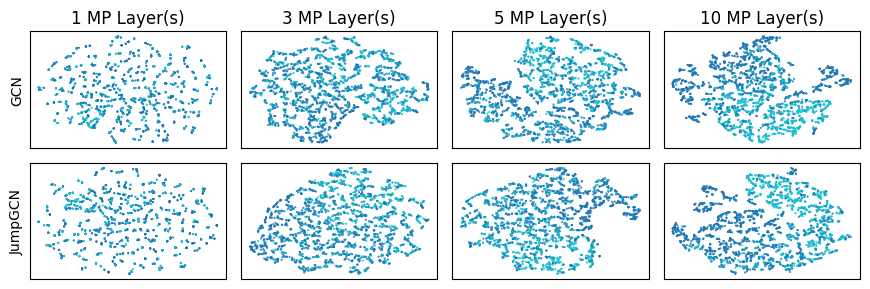

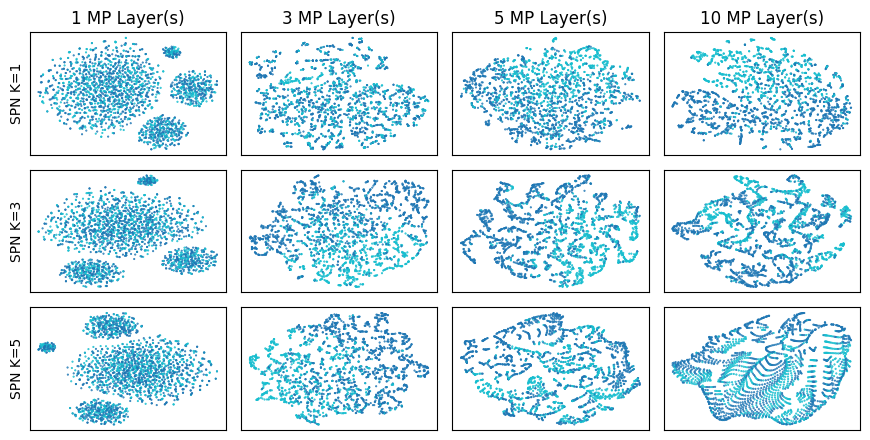

In [55]:
(fig_gcn, _), (fig_spn, _) = plot_embeddings(plotting_data)

In [56]:
fig_gcn.show()
fig_gcn.savefig("synth_gcn_embeddings.png", dpi=512)

In [57]:
fig_spn.show()
fig_spn.savefig("synth_spn_embeddings.png", dpi=512)

In [58]:
save_data(
    gcn_mods,  gcn_embs,  gcn_accs,  gcn_val_accs,
    jump_mods, jump_embs, jump_accs, jump_val_accs,
    spn_mods,  spn_embs,  spn_accs,  spn_val_accs,
    plotting_data,
    "synth_data.pkl"
)

In [59]:
# Load data from the pickle file
with open('synth_data.pkl', 'rb') as f:
    loaded_data = pkl.load(f)

# copy the variables
gcn_mods = loaded_data['models']['gcn']
gcn_embs = loaded_data['embeddings']['gcn']
gcn_accs = loaded_data['accuracies']['gcn']['val']
gcn_val_accs = loaded_data['accuracies']['gcn']['test']
jump_mods = loaded_data['models']['jump_gcn']
jump_embs = loaded_data['embeddings']['jump_gcn']
jump_accs = loaded_data['accuracies']['jump_gcn']['val']
jump_val_accs = loaded_data['accuracies']['jump_gcn']['test']
spn_mods = loaded_data['models']['spn']
spn_embs = loaded_data['embeddings']['spn']
spn_accs = loaded_data['accuracies']['spn']['val']
spn_val_accs = loaded_data['accuracies']['spn']['test']
plotting_data = loaded_data['plotting_data']

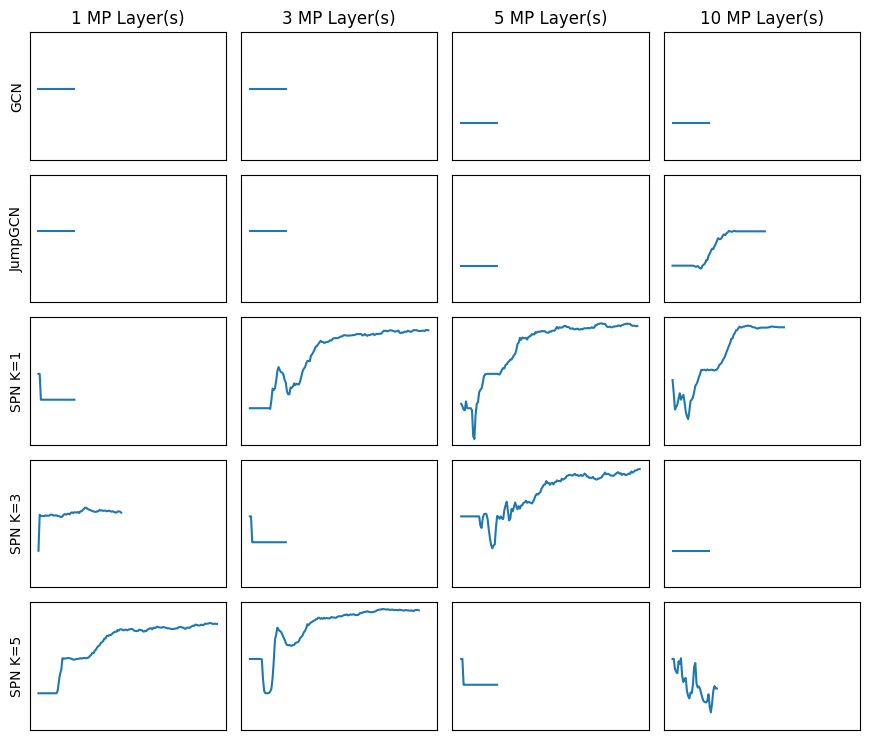

In [60]:
fig, axs = training_report(mp_iters, max_hops, gcn_val_accs, jump_val_accs, spn_val_accs)
fig.show()

# Prepare Download

In [61]:
!zip downloadable_data.zip * -x "*/"

updating: cora_data.pkl (deflated 28%)
updating: cora_gcn_embeddings.png (deflated 1%)
updating: cora_spn_embeddings.png (deflated 1%)
updating: synth_data.pkl (deflated 49%)
updating: synth_gcn_embeddings.png (deflated 1%)
updating: synth_spn_embeddings.png (deflated 1%)


In [62]:
# restore data from zip file
#!unzip downloadable_data.zip